## Итерационные методы для СЛАУ

Рано или поздно размер разреженной системы достигает такой величины, что прямые методы для её решения либо упираются в ограничение по памяти, либо слишком долго работают. В этом случае имеет смысл переходить к итерационным методам решения СЛАУ.

В данный момент для большинства прилолжений используются итерационные методы так называемого [пространства Крылова](https://en.wikipedia.org/wiki/Krylov_subspace).
Наиболее распространенными представителями этих методов являются:
* [Метод сопряженных градиентов](https://en.wikipedia.org/wiki/Conjugate_gradient_method) (conjugate gradients, CG)
* [Стабилизированный метод бисопряженных градиентов](https://en.wikipedia.org/wiki/Biconjugate_gradient_stabilized_method) (biconjugate gradients stabilized, BiCGStab)
* [Обобщенный метод минимальных невязок](https://en.wikipedia.org/wiki/Generalized_minimal_residual_method) (generalized minimum residual, GMRES)

Общие черты этих методов:
* Для решения системы $Ax = b$ не требуется матрица $A$ в явном виде, достаточно описать процедуру вычисления
$x \mapsto Ax$, то есть задать матрицу $A$ в виде линейного оператора.
* Скорость сходимости процесса зависит от числа обусловленности матрицы &mdash; чем хуже обусловлена матрица, тем медленнее сходится метод
* Скорость сходимости можно повысить, если провести предобуславливание системы (об этом позже)

Рассмотрим уравнение Пуассона в единичном квадрате $D = [0, 1]^2$
$$
\Delta u = f\\
u\Big|_{\partial D} = 0
$$

Вводя в области $D$ равномерную сетку с шагом $h = \frac{1}{N}$ и аппроксимируя оператор Лапласа на шаблоне «крест», получаем следующую систему разностных уравнений
$$
\frac{u_{i-1,j} + u_{i,j-1} - 4 u_{i,j} + u_{i,j+1} + u_{i+1, j}}{h^2} = f_{i,j}, \qquad i = 1,\dots,N-1, \; j = 1,\dots, N-1\\
u_{0, j} = u_{N, j} = u_{i,0} = u_{i, N} = 0, \qquad i = 1,\dots,N-1, \; j = 1,\dots, N-1.
$$
Граничные неизвестные проще всего сразу исключить из системы, оставляя лишь $(N-1)^2$ неизвестную во внутренних узлах.

Матрица данной системы положительно определена, поэтому для её решения воспользуемся сопряженными градиентами. В данном случае матрицу системы проще задавать в виде правила, а не в виде разреженной матрицы. Для задания линейного оператора необходимо создать класс **LinearOperator** из **scipy.sparse.linalg**

In [1]:
import numpy as np
from scipy.sparse.linalg import cg, LinearOperator
import matplotlib.pyplot as plt

%matplotlib inline
plt.rc("font", size=14)
plt.rc("figure", figsize=(8, 7))

Объявим класс **LaplaceOperator**, который является наследником **LinearOperator**. При создании **LaplaceOperator** достаточно указать лишь размер области $N$.

Так как неизвестным в линеной системе может быть лишь вектор, необходимо упаковать элементы $u_{i,j}$ в виде одномерного вектора. Для этого удобно пользоваться функцией **np.reshape**. При такой упаковке элементы складываются в вектор по строкам матрицы.

In [2]:
Z = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])
print('Z = \n', Z)
#-1 означает, что размер вектора должен быть вычислен исходя из числа элементов в исходном массиве
print('Z.reshape(-1) = \n', Z.reshape(-1)) 
v = np.arange(8)
print('v =', v)
print('v.reshape(2, 4) = \n', v.reshape(2, 4))

Z = 
 [[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]
Z.reshape(-1) = 
 [ 1  2  3  4  5  6  7  8  9 10 11 12]
v = [0 1 2 3 4 5 6 7]
v.reshape(2, 4) = 
 [[0 1 2 3]
 [4 5 6 7]]


In [3]:
class LaplaceOperator(LinearOperator):
    def __init__(self, N):
        nvars = (N-1)**2 # Число неизвестных в системе
        
        # Для инициализации родителя (LinearOperator) нужно задать размер матрицы и тип элементов
        super().__init__(shape=(nvars, nvars), dtype=np.double)
        
        # Запоминаем в self значения N и h
        self.N = N
        self.h = 1.0 / N
        
    # Функция, вычисляющая Ax по заданному x
    def _matvec(self, x):
        N = self.N                # Извлекаем N из self для удобства
        u = np.zeros((N+1, N+1))  # Сюда мы поместим элементы из x
        
        # Превращаем x в двумерный массив размера N-1 x N-1 и помещаем в центр u
        # По краям образуются нули - как раз в тех местах, где стоят граничные условия
        u[1:-1, 1:-1] = x.reshape(N-1, N-1)
        
        # Дискретный оператор Лапласа от u в виде двумерного массива размера N-1 x N-1
        Lu = (u[:-2, 1:-1] + u[1:-1, :-2] - 4*u[1:-1, 1:-1] + u[2:, 1:-1] + u[1:-1, 2:]) / self.h**2
        
        # Он же, но вытянутый в одномерный вектор
        return Lu.reshape(-1)

Проверим, как работает наш оператор Лапласа

In [4]:
def f_fun(x, y):
    return np.sin(np.pi * x) * y * (1-y)

def Lf_fun(x, y):
    return -np.pi**2 * f_fun(x, y) - 2 * np.sin(np.pi * x)

In [5]:
# Функция, возвращающая два массива X[i,j] = ih и Y[i,j] = jh
# Удобно для вычисления f на всей сетке
def grid(N):
    x = np.linspace(0, 1, N+1)
    y = np.linspace(0, 1, N+1)
    return np.meshgrid(x, y, indexing='ij')

In [6]:
N = 20
X, Y = grid(N)
f = f_fun(X, Y)
Lfex = Lf_fun(X, Y)

In [7]:
lap = LaplaceOperator(N)

# Учитываем, что lap принимает и выдает вектор
# Делаем reshape для входа и для выхода
Lf = lap(f[1:-1, 1:-1].reshape(-1)).reshape(N-1, N-1)

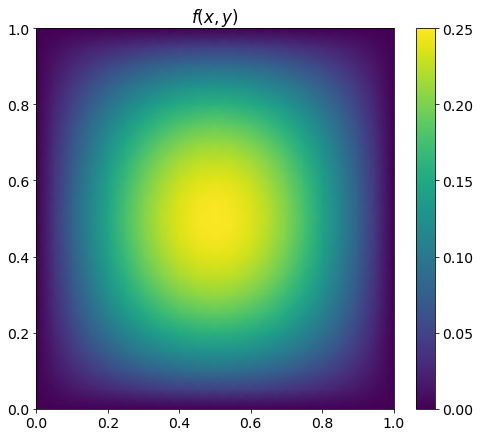

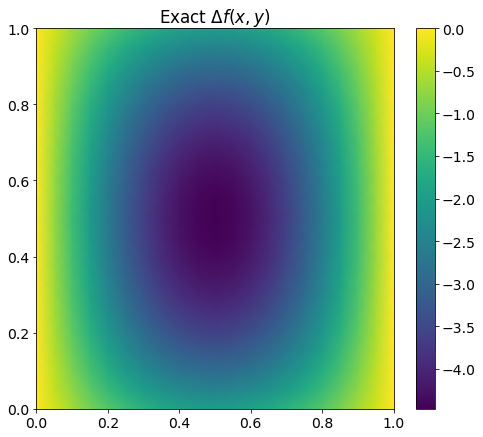

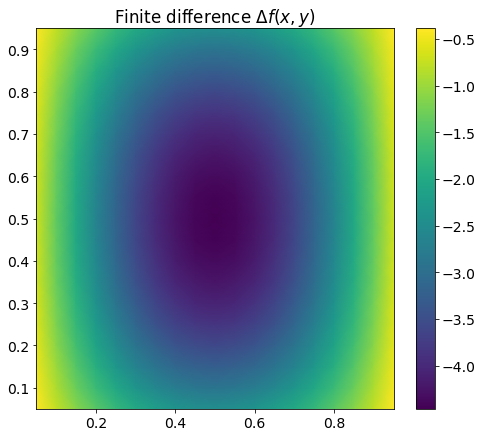

In [8]:
plt.pcolormesh(X, Y, f, shading='gouraud')
plt.title('$f(x, y)$')
plt.colorbar()
plt.figure()
plt.pcolormesh(X, Y, Lfex, shading='gouraud')
plt.title('Exact $\Delta f(x, y)$')
plt.colorbar()
plt.figure()
plt.pcolormesh(X[1:-1, 1:-1], Y[1:-1, 1:-1], Lf, shading='gouraud')
plt.title('Finite difference $\Delta f(x, y)$')
plt.colorbar()

После того, как мы убедились, что **LaplaceOperator** работает, можно решать систему уравнений с ним. Также на каждом шаге будем запоминать норму невязки, то есть величину $||Ax_k - f||$

In [9]:
N = 500
X, Y = grid(N)
f = f_fun(X, Y)                 # Правая часть
rhs = f[1:-1, 1:-1].reshape(-1) # только внутренние узлы, вытягиваем в вектор

lap = LaplaceOperator(N)

residuals = []
# Эта функция будет вызываться после каждой итерации
def callback(x):
    global residuals # Использовать residuals, объявленую вне функции callback
    residuals.append(np.linalg.norm(lap(x) - rhs))

x, flag = cg(lap, rhs, tol=1e-6, maxiter=200, callback=callback)
# Если flag = 0 - успешное завершение
# Если flag < 0 - произошла ошибка при вычислении lap
# Если flag > 0 - успешно сдлеано flag итераций, но условие выхода не выполнено
print('Результат CG:', flag)

u = np.zeros((N+1, N+1))
u[1:-1, 1:-1] = x.reshape(N-1, N-1)

Результат CG: 200


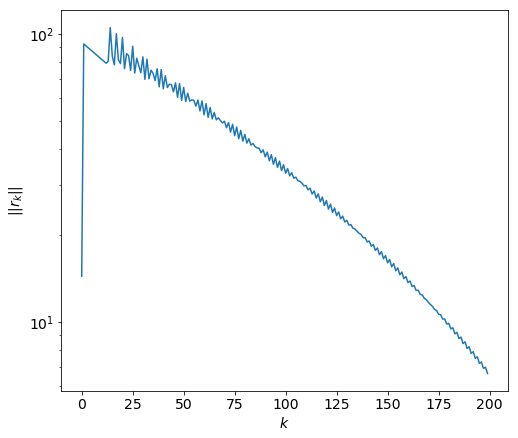

In [10]:
# Начертим график убывания невязки
plt.semilogy(residuals)
plt.xlabel('$k$')
plt.ylabel('$||r_k||$')

 Известно, что число обусловленности матрицы оператора Лапласа $\kappa(A) \sim N^2$. При этом для успешной сходимости метода сопряженных градиентов необходимо сделать $\sim N$ итераций. Для больших задач это достаточно много.

Для успешного решения системы итерационным методом требуется как-нибудь снизить число обусловленности матрицы системы. Для этого, например, систему можно умножить слева на некотороую матрицу $M^{-1}$:
$$
Ax = b\\
M^{-1} A x = M^{-1} x
$$
Если число обусловленности $M^{-1} A$ невелико, а системы вида $Mz = f$ решаются не очень сложно, то такая матрица может значительно ускорить сходимость итерационного процесса. В идеале желательно взять $M \approx A$, но так, чтобы систему $Mz = f$ можно было еще сравнительно просто решить.

Матрицы, снижающие обусловленность системы называются предобуславливателями. Все итерационные методы решения линейных систем принимают параметр $M$, выполняющий эту роль. Причем этот параметр также может являться линейным оператором, то есть функцией $x \mapsto M^{-1} x$.

Довольно часто на роль $M$ выбирают неполное LU разложение разреженной матрицы $A$. Неполным LU разложением $A$ называется
$$
A = LU + R, \qquad M = LU
$$
где матрица $R$ отбрасывается. Правила отбрасывания элементов задают различные неполные разложения:
* ILU(0) &mdash; в процессе LU разложения отбрасываются все элементы, которые не помещаются в портрет ненулевых элементов матрицы $A$
* ILU(k) &mdash; то же, но отбрасываются элементы, не помещающиеся в портрет $A^{k+1}$
* ILUT &mdash; отбрасываются слишком маленькие элементы

К сожалению, использование ILU предобуславливателей требует хранения матрицы системы в одном из разреженных форматов.
Для решения системы $Mz = f$ используется стандартный алгоритм решения сначала системы $Ly = f$, а затем $Uz = y$, но только матрицы $L, U$ являются разреженными.

<h1 style="color:red">Задание 1</h1> Дописать функцию **LaplaceOperatorMatrix**, формирующую разреженную матрицу оператора Лапласа размера $(N-1)^2 \times (N-1)^2$. 

In [11]:
# Находит номер элемента u_{i,j} в вытянутом векторе неизвестных x = u[1:-1, 1:-1].reshape(-1)
# i,j принимают значения 1, ..., N-1
# номер элемента принимает значения от 0 до (N-1)**2 - 1
def ij2index(i, j, N):
    assert i > 0 and i < N and j > 0 and j < N, 'Индексы вышли за допустимые пределы'
    return (i-1) * (N-1) + j-1

def test_ij2index(N=10):
    u = np.random.rand(N+1, N+1)
    uvec = u[1:-1, 1:-1].reshape(-1)
    for i in range(1, N):
        for j in range(1, N):
            assert uvec[ij2index(i, j, N)] == u[i, j], 'Условие нарушено в элементе ' + str((i, j))
            
test_ij2index()

In [12]:
from scipy.sparse import coo_matrix

In [13]:
def LaplaceOperatorMatrix(N):
    h = 1.0 / N
    rows = []
    cols = []
    vals = []
    # Этот цикл нужно дописать и починить
    for i in range(1, N):
        for j in range(1, N):
            
            if i != 1:
                # В уравнение (i,j) входит неизвестная (i-1,j) с коэффициентом 1/h^2
                row = ij2index(i, j, N)   # Номер уравнения в узле (i,j)
                col = ij2index(i-1, j, N) # Номер неизвестной в узле (i-1, j)
                rows.append(row)
                cols.append(col)
                vals.append(1 / h**2)
        
            if j != 1:
                row = ij2index(i, j, N)   # Номер уравнения в узле (i,j)
                col = ij2index(i, j-1, N) # Номер неизвестной в узле (i-1, j)
                rows.append(row)
                cols.append(col)
                vals.append(1 / h**2)
                
            row = ij2index(i, j, N)   # Номер уравнения в узле (i,j)
            col = ij2index(i, j, N) # Номер неизвестной в узле (i-1, j)
            rows.append(row)
            cols.append(col)
            vals.append(-4 / h**2)
        
            if j != N-1:          
                row = ij2index(i, j, N)   # Номер уравнения в узле (i,j)
                col = ij2index(i, j+1, N) # Номер неизвестной в узле (i-1, j)
                rows.append(row)
                cols.append(col)
                vals.append(1 / h**2)
            
            if i != N-1:  
                row = ij2index(i, j, N)   # Номер уравнения в узле (i,j)
                col = ij2index(i+1, j, N) # Номер неизвестной в узле (i-1, j)
                rows.append(row)
                cols.append(col)
                vals.append(1 / h**2)
            
    return coo_matrix((vals, (rows, cols)))

In [14]:
def test_matrix_and_operator_are_same(N=10):
    lap = LaplaceOperator(N)
    mat = LaplaceOperatorMatrix(N)
    
    # Проверяем равенство на случайном векторе
    x = np.random.rand((N-1)**2)
    y = lap(x)
    z = mat @ x
    print('||y-z|| / ||y|| = ', np.linalg.norm(y-z) / np.linalg.norm(y))
    assert np.allclose(y, z), 'Матрица и оператор дают различные произведения!'
    
test_matrix_and_operator_are_same()

||y-z|| / ||y|| =  1.71179580279e-16


Убедитесь, что сопряженные градиенты все так же плохо сходятся с матрицей вместо оператора

In [15]:
A = LaplaceOperatorMatrix(N)

Результат CG: 200
Wall time: 4.35 s


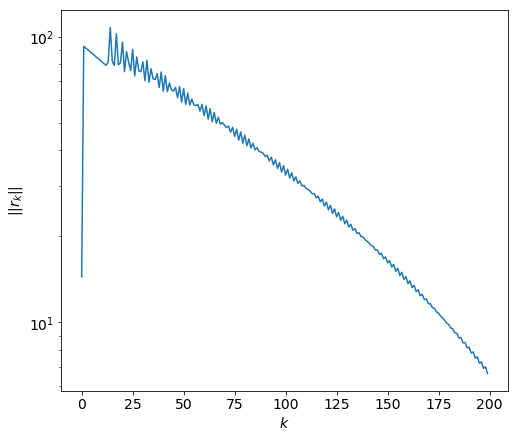

In [16]:
%%time

residuals = []
# Эта функция будет вызываться после каждой итерации
def callback(x):
    global residuals # Использовать residuals, объявленую вне функции callback
    residuals.append(np.linalg.norm(A @ x - rhs))

x, flag = cg(A, rhs, tol=1e-6, maxiter=200, callback=callback)
# Если flag = 0 - успешное завершение
# Если flag < 0 - произошла ошибка при вычислении lap
# Если flag > 0 - успешно сдлеано flag итераций, но условие выхода не выполнено
print('Результат CG:', flag)

u = np.zeros((N+1, N+1))
u[1:-1, 1:-1] = x.reshape(N-1, N-1)

plt.semilogy(residuals)
plt.xlabel('$k$')
plt.ylabel('$||r_k||$')

К моему удивлению, в **scipy** есть только предобуславливатель **scipy.sparse.linalg.spilu**, представляющий собой разновидность ILUT. Поэтому ILU0 был взят из библиотеки SPARSKIT (код транслирован с Fortran, для ускорения работы с массивами использована jit компиляция с помощью библиотеки numba). Код компилируется с указанием не использовать Python (самый быстрый режим), из-за этого все вспомогательные массивы должны передаваться в функции снаружи.

In [17]:
from numba import jit

@jit('(i4[:], i4[:], f8[:], i4[:], f8[:], f8[:])', nopython=True)
def lusolve(ia, ja, lu, idv, dv, y):
    # Решаем (L+E)x = y на месте (поместить x в y)
    n = len(y)
    for i in range(n):
        for p in range(ia[i], idv[i]):
            y[i] -= lu[p] * y[ja[p]]

    # Теперь решаем Ux = y на месте
    # dv[i] = 1 / U[i, i];  сами U[i, i] не используются
    for i in range(n-1, -1, -1):
        # Пропускаем диагональный элемент с p = idv[i]
        for p in range(idv[i]+1, ia[i+1]):
            y[i] -= lu[p] * y[ja[p]]
        y[i] *= dv[i];

@jit('(i4[:], i4[:], f8[:], f8[:], i4[:], f8[:], i4[:])', nopython=True)
def ilu0(ia, ja, a, lu, idv, dv, jinv):
    # jinv - это специальная таблица поиска индекса в массиве ja по номеру столбца
    n = len(jinv)
    for i in range(n):
        jinv[i] = -1

    for i in range(n):
        for p in range(ia[i], ia[i+1]):
            j = ja[p]
            lu[p] = a[p] # Заполняем i-ю строку LU элементами из A
            jinv[j] = p  # Заполняем jinv для i-й строки

            if j == i: # Нашли диагональный элемент
                idv[i] = p;

        for p in range(ia[i], idv[i]): # Идем по всем ненулевым элеметам в i-й строке L
            j = ja[p]
            lv = lu[p] * dv[j] # Делим L[i, j] га U[j, j]
            lu[p] = lv         # lv нам еще понадобится

            # Вычитаем lv * U[j, j+1:] из LU[i, j+1:], но пропускаем
            # элементы, для которых нет места в портрете i-th строки
            for q in range(idv[j]+1, ia[j+1]):
                k = ja[q]
                if jinv[k] >= 0: # Если LU[i, k] есть в портртете
                    lu[jinv[k]] -= lv * lu[q] # LU[i, k] -= lv * LU[j, k]

        dv[i] = 1 / lu[idv[i]] # Запоминаем 1 / U[i, i] как dv[i]

        # Очищаем jinv для следующей строки. Нельзя просто заполнить весь вектор
        # числами -1, так как при этом получится сложность алгоритма O(n^2).
        # Так что просто отменяем то, что сделали в начале
        for p in range(ia[i], ia[i+1]):
            j = ja[p]
            jinv[j] = -1
            
@jit('(i4[:], i4[:], f8[:], i4[:], i4[:], f8[:])', nopython=True)
def bloat(ia, ja, a, ib, jb, b):
    n = len(ia) - 1
    for i in range(n):
        # Копируем ненулевые элементы i-й строки из A в B
        p = ia[i]
        j = ja[p]
        for q in range(ib[i], ib[i+1]):
            if jb[q] != j:
                b[q] = 0    # В A нет такого элемента, помещаем в B на это место ноль
            else:
                b[q] = a[p] # Копируем соответствующий элемент из A
                p += 1      # и переходим к следующему ненулевому элементу A
                if p < len(ja):
                    j = ja[p]
                else:
                    j = n   # Дошли до конца матрицы A, но B еще не закончилась
        assert p == ia[i+1]

Опишем предобуславливатель как линейный оператор

In [18]:
class ILU0Preconditioner(LinearOperator):
    # Строит ILU0 разложение A и запоминает его в self
    def __init__(self, A):
        super().__init__(shape=A.shape, dtype=A.dtype)
        
        Acsr = A
        if A.format != 'csr': # код ILU0 ожидает, что матрица дана в CSR
            Acsr = A.tocsr()
        
        ia = Acsr.indptr   
        ja = Acsr.indices
        a  = Acsr.data
        lu = np.zeros_like(a) # Под lu требуется столько же места, что и под a
        idv  = np.zeros(A.shape[0], dtype=np.int32) # Номера диагональных элементов
        dv   = np.zeros(A.shape[0], dtype=a.dtype)  # Обратные к диагональным элементам
        jinv = np.zeros(A.shape[0], dtype=np.int32) # Вспомогательный массив
        
        ilu0(ia, ja, a, lu, idv, dv, jinv)
        
        self.ia  = ia.copy() # Структура у LU та же, что и у A - особенность ILU0
        self.ja  = ja.copy()
        self.lu  = lu
        self.idv = idv
        self.dv  = dv
        
    # Решает систему LUx = rhs
    def _matvec(self, rhs):
        x = rhs.copy()
        
        lusolve(self.ia, self.ja, self.lu, self.idv, self.dv, x)
        
        return x

In [19]:
%time M_ilu0 = ILU0Preconditioner(A)

Wall time: 142 ms


In [20]:
%%time
residuals_ilu0 = []

def callback(x):
    global residuals_ilu0
    residuals_ilu0.append(np.linalg.norm(A @ x - rhs))

x, flag = cg(A, rhs, M=M_ilu0, tol=1e-6, maxiter=200, callback=callback)
# Если flag = 0 - успешное завершение
# Если flag < 0 - произошла ошибка при вычислении lap
# Если flag > 0 - успешно сдлеано flag итераций, но условие выхода не выполнено
print('Результат CG:', flag)

u = np.zeros((N+1, N+1))
u[1:-1, 1:-1] = x.reshape(N-1, N-1)

Результат CG: 0
Wall time: 5.02 s


При наличии предобуславливателя ILU(0) довольно легко можно реализовать ILU(k). Для этого достаточно возвести матрицу в степень, умножив на себя $k$ раз, далее не меняя портрета матрицы записать в неё ненулевые элементы $A$, а на остальные места положить нули. При этом портрет матрицы расширится до портрета $A^{k+1}$, а значения элементов останутся прежними. При этом ILU(0) сможет использовать для хранения LU портрет матрицы $A^{k+1}$, и, фактически, будет работать как ILU(k) для исходной матрицы.

In [21]:
class ILUKPreconditioner(ILU0Preconditioner):
    def __init__(self, A, k):
        if A.format != 'csr':
            A = A.tocsr()        

        # Раздуваем портрет матрицы A. Для этого возводим её в степень k+1            
        A.sort_indices()
        B = A.copy()
        for i in range(k):
            B = B * A
        B.sort_indices()
        print('После возведения в степень число ненулевых элементов выросло в', B.nnz / A.nnz, 'раз')

        n = B.shape[0]
        ia = A.indptr
        ja = A.indices
        a  = A.data
        
        ib = B.indptr
        jb = B.indices
        b  = B.data
        
        # Записать элементы A в матрицу B не меняя структуры B
        bloat(ia, ja, a, ib, jb, b)
        
        # Убедимся, что B и A теперь одно и то же (операция - убирает лишние нули)
        assert (B - A).nnz == 0
        
        super().__init__(B)
        
    # В остальном ILUK ведет себя в точности как свой родитель - ILU0Preconditioner

In [22]:
%%time
M_iluk = ILUKPreconditioner(A, k=5)

После возведения в степень число ненулевых элементов выросло в 16.881397479825168 раз
Wall time: 4.21 s


In [23]:
%%time
residuals_iluk = []

def callback(x):
    global residuals_iluk
    residuals_iluk.append(np.linalg.norm(A @ x - rhs))

x, flag = cg(A, rhs, M=M_iluk, tol=1e-6, maxiter=200, callback=callback)
# Если flag = 0 - успешное завершение
# Если flag < 0 - произошла ошибка при вычислении lap
# Если flag > 0 - успешно сдлеано flag итераций, но условие выхода не выполнено
print('Результат CG:', flag)

u = np.zeros((N+1, N+1))
u[1:-1, 1:-1] = x.reshape(N-1, N-1)

Результат CG: 0
Wall time: 7 s


Начертим графики сходимости сопряженных градиентов с разными предобуславливателями.

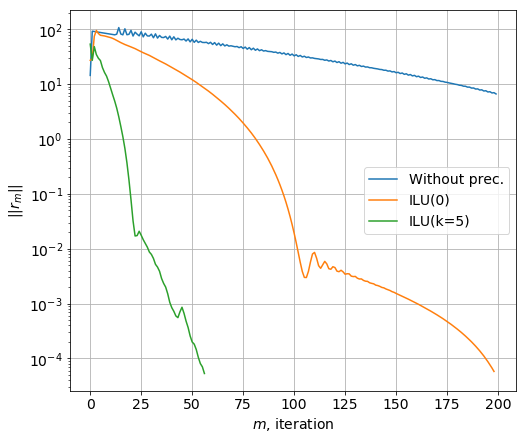

In [24]:
plt.semilogy(residuals, label='Without prec.')
plt.semilogy(residuals_ilu0, label='ILU(0)')
plt.semilogy(residuals_iluk, label='ILU(k=5)')
plt.xlabel('$m$, iteration')
plt.ylabel('$||r_m||$')
plt.legend(loc='best')
plt.grid()

<h1 style="color:red">Задание 2</h1> Выяснить, при каком из $k = 0, \dots, 5$ метод с предобуславливателем ILU(k) быстрее всего сходится (по времени работы Wall time).

In [25]:
import time

In [26]:
times_prec = []
times_cg = []
iters_num = []

class ItersCounter:
    def __init__(self):
        self.maxIter = 0
        
    def __call__(self, x):
        self.maxIter += 1
        
        
for k in range(6):
    callback = ItersCounter()
    t1 = time.clock()
    M_iluk = ILUKPreconditioner(A, k=k)
    t2 = time.clock()
    x, flag = cg(A, rhs, M=M_iluk, tol=1e-6, maxiter=200, callback=callback)
    t3 = time.clock()
    times_cg.append(t3 - t2)
    times_prec.append(t2 - t1)
    iters_num.append(callback.maxIter)
    assert flag == 0, 'smth wrong happened'

После возведения в степень число ненулевых элементов выросло в 1.0 раз
После возведения в степень число ненулевых элементов выросло в 2.5961493440514105 раз
После возведения в степень число ненулевых элементов выросло в 4.985564062689812 раз
После возведения в степень число ненулевых элементов выросло в 8.165042248286214 раз
После возведения в степень число ненулевых элементов выросло в 12.13138521120925 раз
После возведения в степень число ненулевых элементов выросло в 16.881397479825168 раз


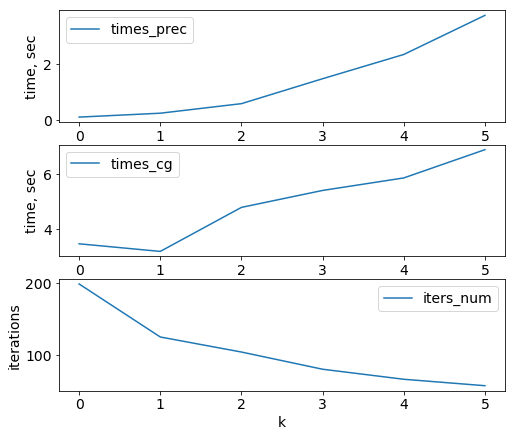

In [27]:
plt.subplot(311)
plt.plot(range(6) , times_prec, label='times_prec')
plt.ylabel('time, sec')
plt.xlabel('k')
plt.legend()

plt.subplot(312)
plt.plot(range(6) , times_cg, label='times_cg')
plt.ylabel('time, sec')
plt.xlabel('k')
plt.legend()

plt.subplot(313)
plt.plot(range(6) , iters_num, label='iters_num')
plt.ylabel('iterations')
plt.xlabel('k')
plt.legend()

In [28]:
times_cg_no_callback = []
        
for k in range(6):
    
    M_iluk = ILUKPreconditioner(A, k=k)
    t1 = time.clock()
    x, flag = cg(A, rhs, M=M_iluk, tol=1e-6, maxiter=200)
    t2 = time.clock()
    times_cg_no_callback.append(t2-t1)
    assert flag == 0, 'smth wrong happened'

После возведения в степень число ненулевых элементов выросло в 1.0 раз
После возведения в степень число ненулевых элементов выросло в 2.5961493440514105 раз
После возведения в степень число ненулевых элементов выросло в 4.985564062689812 раз
После возведения в степень число ненулевых элементов выросло в 8.165042248286214 раз
После возведения в степень число ненулевых элементов выросло в 12.13138521120925 раз
После возведения в степень число ненулевых элементов выросло в 16.881397479825168 раз


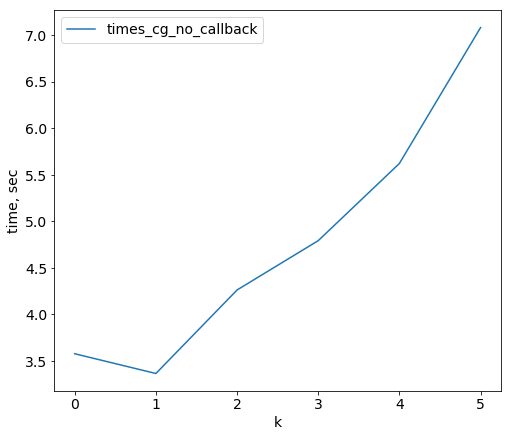

In [29]:
plt.plot(range(6) , times_cg_no_callback, label='times_cg_no_callback')
plt.ylabel('time, sec')
plt.xlabel('k')
plt.legend()

<b> k=1 - опитмальное значение </b>